In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 
import random 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


#%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

In [2]:
df = pd.read_csv("Data/dataset.csv")
df.head(2)

,Date,SMI,SP500,USD_CHF,BondCH,BondUS
0,2003-09-17,5398.899902,1025.97,1.3807,3.700,5.71
1,2003-09-18,5422.600098,1039.58,1.3858,3.716,5.69


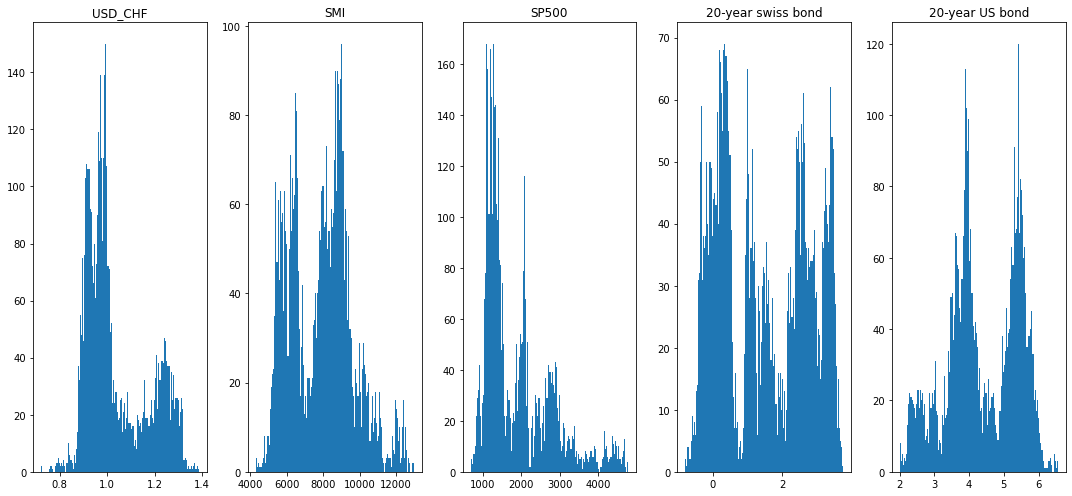

In [3]:
data = [df.USD_CHF, df.SMI, df.SP500, df.BondCH, df.BondUS]

fig = plt.figure(figsize=(15, 7))

name  = ['USD_CHF','SMI', 'SP500', '20-year swiss bond', '20-year US bond']
for i in range(len(data)):   
    plt.subplot(1,len(data),1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

Shape:             
X train     (3445, 7, 5), y train     (3445, 5)            
X train val (383, 7, 5) , y train val (383, 5)             
X test      (676, 7, 5) , y test      (676, 5)


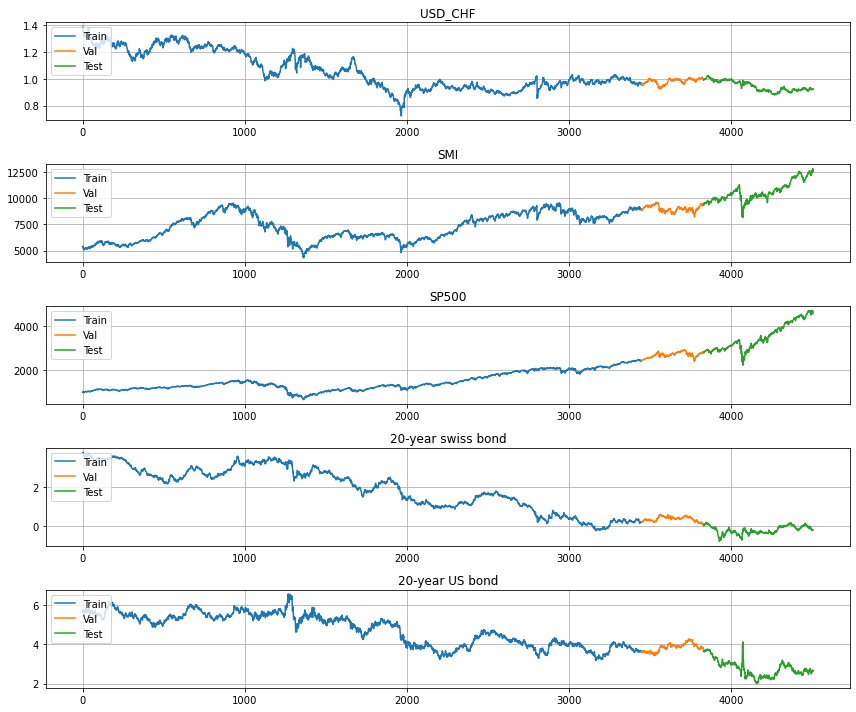

In [11]:
device = 'cpu'
LOOKBACK = 7
NORM = True
trend = True
train_x, val_x, test_x, train_y, val_y, test_y, norm = pp.generate_dataset(data, lookback_=LOOKBACK, trend_=trend, norm_=NORM, fraction_val_=0.1, fraction_test_=0.15)

l1 = len(train_x)
l2 = len(val_x) + l1
l3 = len(test_x) + l2 

fig = plt.figure(figsize=(12, 10))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(nb_data,1,i+1)
  plt.title(name[i])
  plt.plot(np.arange(l1), data[i].iloc[:l1], label='Train')
  plt.plot(np.arange(l1, l2), data[i].iloc[l1:l2], label='Val')
  plt.plot(np.arange(l2,l3), data[i].iloc[l2:l3], label='Test')
  plt.grid()
  plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Trend Prediction

In [245]:
buff = train_y[:, 0]
positive_weight = torch.tensor(
        len(buff[buff == 0.0]) / len(buff[buff == 1.0])
    ).float().to(device)

buff = val_y[:, 0]
buff.sum()/len(buff)

0.5195822454308094

### GRU 1-feature

In [211]:
model_gru_1 = ml.GRU_base(
        hidden_size=8,
        num_layers=1,
        input_size=1,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_1.to(device)
model_gru_1

GRU_base(
  (gru): GRU(1, 8, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=8, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 50/50 [00:02<00:00, 17.20it/s]


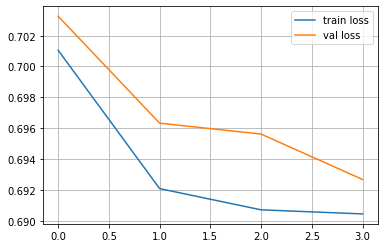

In [212]:
lr= 0.001
num_epochs= 50

train_loss, val_loss = pl.train(
    model=model_gru_1,
    train_x_ = train_x[:,:,0].reshape(-1, LOOKBACK, 1),
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x[:,:,0].reshape(-1, LOOKBACK, 1),
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [213]:
_, _, ACC_gru_1 = pl.evaluate_trend(model_gru_1, val_x[:,:,0].reshape(-1, LOOKBACK,1), val_y[:, 0], device="cpu", verbose=1)


ACC:  0.52219
nb 0 = 181; nb 1 = 202


### GRU 5-feature

In [224]:
model_gru_5 = ml.GRU_base(
        hidden_size=8,
        num_layers=1,
        input_size=5,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_5.to(device)
model_gru_5

GRU_base(
  (gru): GRU(5, 8, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=8, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 40/40 [00:02<00:00, 17.64it/s]


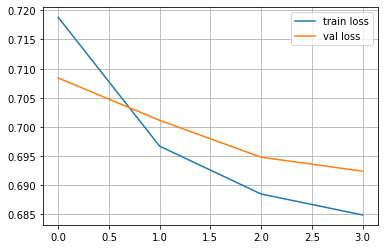

In [225]:
lr= 0.001
num_epochs= 40

train_loss, val_loss = pl.train(
    model=model_gru_5,
    train_x_ = train_x,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [226]:
_, _, ACC_gru_5 = pl.evaluate_trend(model_gru_5, val_x, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.54047
nb 0 = 160; nb 1 = 223


### GRU + Auto-Encoder 1-feature 

In [227]:
model_autoenc_1 = ml.auto_encoder(nb_channel_conv=3)
model_autoenc_1.load_state_dict(torch.load('Helper/model/model_autoenc_1.pth'))
model_autoenc_1.to(device)
model_autoenc_1

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(3, 1, kernel_size=(3,), stride=(1,))
)

In [240]:
model_gru_autoenc_1 = ml.GRU_base(
        hidden_size=8,
        num_layers=1,
        input_size=1,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_autoenc_1.to(device)
model_gru_autoenc_1

GRU_base(
  (gru): GRU(1, 8, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=8, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 40/40 [00:02<00:00, 18.15it/s]


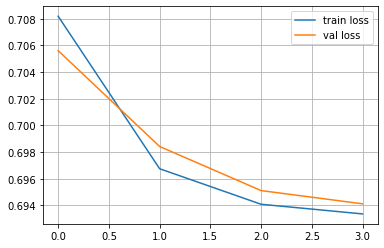

In [241]:
model_autoenc_1.eval()
inp1 = torch.from_numpy(train_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp1.to(device).float())
train_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

inp2 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp2.to(device).float())
val_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

lr= 0.001
num_epochs= 40

train_loss, val_loss = pl.train(
    model=model_gru_autoenc_1,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [242]:
inp3 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp3.to(device).float())
val_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

_, _, ACC_gru_autoenc_1 = pl.evaluate_trend(model_gru_autoenc_1, val_x_smooth, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.53525
nb 0 = 166; nb 1 = 217


### Dense + latent space Auto-Encoder 1-feature 

In [279]:
model_dense_autoenc_1 = ml.Dense(
    num_layers=2,
    layer_size=8,
    input_size=3,
    output_size=1,
    dropout=0.05
    )
model_dense_autoenc_1.to(device)
model_dense_autoenc_1

Dense(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

100%|██████████| 25/25 [00:00<00:00, 32.25it/s]


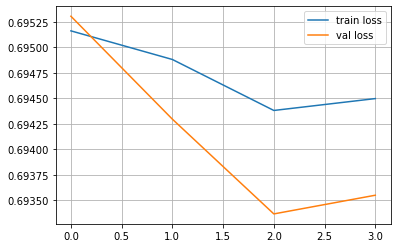

In [284]:
model_autoenc_1.eval()
inp1 = torch.from_numpy(train_x[:,:,0].reshape(-1, 1, LOOKBACK))
out, latent = model_autoenc_1(inp1.to(device).float(), return_latent=True)
train_x_smooth = latent.cpu().detach().numpy().reshape(-1, 3)

inp2 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out, latent = model_autoenc_1(inp2.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1, 3)

lr= 0.001
num_epochs= 25 

train_loss, val_loss = pl.train(
    model=model_dense_autoenc_1,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()


In [375]:
inp3 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out,latent = model_autoenc_1(inp3.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1,3)

_, _, ACC_dense_autoenc_1 = pl.evaluate_trend(model_dense_autoenc_1, val_x_smooth, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.53786
nb 0 = 173; nb 1 = 210


### GRU + Auto-Encoder 5-feature 

In [287]:
model_autoenc_5 = ml.auto_encoder(input_size=5,
    nb_channel_conv=15)
model_autoenc_5.load_state_dict(torch.load('Helper/model/model_autoenc_5.pth'))
model_autoenc_5.to(device)
model_autoenc_5

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(5, 15, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(15, 5, kernel_size=(3,), stride=(1,))
)

In [354]:
model_gru_autoenc_5 = ml.GRU_base(
        hidden_size=16,
        num_layers=1,
        input_size=5,
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_autoenc_5.to(device)
model_gru_autoenc_5

GRU_base(
  (gru): GRU(5, 16, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 17/17 [00:00<00:00, 17.97it/s]


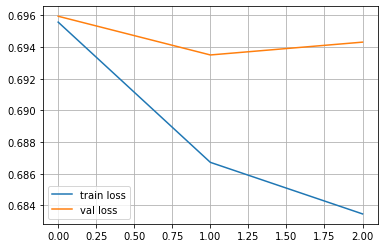

In [355]:
model_autoenc_5.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x,1,2))
out = model_autoenc_5(inp1.to(device).float())
train_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

inp2 = torch.from_numpy(np.swapaxes(val_x,1,2))
out = model_autoenc_5(inp2.to(device).float())
val_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

lr= 0.001
num_epochs= 17

train_loss, val_loss = pl.train(
    model=model_gru_autoenc_5,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/3)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()


In [376]:
inp3 = torch.from_numpy(np.swapaxes(val_x,1,2))
out = model_autoenc_5(inp3.to(device).float())
val_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)


_, _, ACC_gru_autoenc_5 = pl.evaluate_trend(model_gru_autoenc_5, val_x_smooth, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.54569
nb 0 = 218; nb 1 = 165


### Dense + latent space Auto-Encoder 5-feature 

In [361]:
model_dense_autoenc_5 = ml.Dense(
    num_layers=2,
    layer_size=8,
    input_size=15,
    output_size=1,
    dropout=0.05
    )
model_dense_autoenc_5.to(device)
model_dense_autoenc_5

Dense(
  (net): Sequential(
    (0): Linear(in_features=15, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

100%|██████████| 15/15 [00:00<00:00, 25.53it/s]


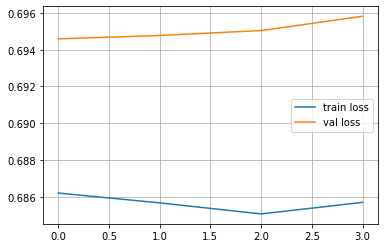

In [368]:
model_autoenc_5.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x,1,2))
out, latent = model_autoenc_5(inp1.to(device).float(), return_latent=True)
train_x_smooth = latent.cpu().detach().numpy().reshape(-1, 15)

inp2 = torch.from_numpy(np.swapaxes(val_x,1,2))
out, latent = model_autoenc_5(inp2.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1, 15)

lr= 0.001
num_epochs= 15

train_loss, val_loss = pl.train(
    model=model_dense_autoenc_5,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [373]:
inp3 = torch.from_numpy(np.swapaxes(val_x,1,2))
out, latent = model_autoenc_5(inp3.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1,15)

_, _, ACC_dense_autoenc_5 = pl.evaluate_trend(model_dense_autoenc_5, val_x_smooth, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.48042
nb 0 = 153; nb 1 = 230


In [377]:
print(f"ACC GRU 1-feature:                             { ACC_gru_1: 0.08f}")
print(f"ACC GRU 5-features:                            { ACC_gru_5: 0.08f}")
print(f"ACC GRU Auto-Encoder 1-feature:                { ACC_gru_autoenc_1: 0.08f}")
print(f"ACC Dense latent space Auto-Encoder 1-feature: { ACC_dense_autoenc_1: 0.08f}")
print(f"ACC GRU Auto-Encoder 5-feature:                { ACC_gru_autoenc_5: 0.08f}")
print(f"ACC Dense latent space Auto-Encoder 5-feature: { ACC_dense_autoenc_5: 0.08f}")


ACC GRU 1-feature:                              0.52219321
ACC GRU 5-features:                             0.54046997
ACC GRU Auto-Encoder 1-feature:                 0.53524804
ACC Dense latent space Auto-Encoder 1-feature:  0.53785901
ACC GRU Auto-Encoder 5-feature:                 0.54569191
ACC Dense latent space Auto-Encoder 5-feature:  0.48041775


nb 0 = 211; nb 1 = 172
0.5248041775456919


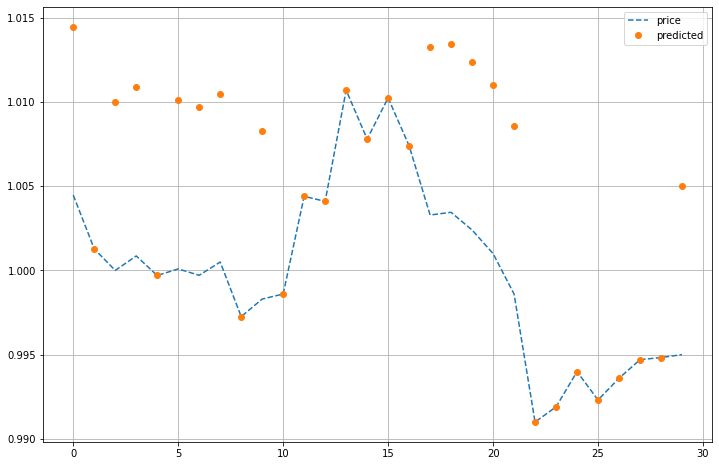

In [12]:
model_gru_trend.eval()
inp = torch.from_numpy(np.array(val_x_norm))
labs = torch.from_numpy(np.array(val_y_bool[:, 0]))
out = model_gru_trend(inp.float()) #.to('cuda')

outputs = nn.Sigmoid()(out).cpu().detach().numpy().reshape(-1).round()
print(f"nb 0 = {len(outputs[outputs == 0.])}; nb 1 = {len(outputs[outputs == 1.])}")
targets = labs.numpy().reshape(-1)
ACC = np.mean((outputs == targets))
print(ACC)

nb = 30
plt.figure(figsize=(12,8))
plt.plot(val_y[-nb:,0], '--', label='price')
#plt.plot(val_y[-nb:,0]+targets[-nb:]/100+0.001, 'o', label='real')
plt.plot(val_y[-nb:,0]+outputs[-nb:]/100, 'o', label='predicted')
plt.legend()
plt.grid()
plt.show()

In [21]:
gru_model_aux = ml.ExchangeRateNet(num_layers=1)
#gru_model_aux.to('cuda')
gru_model_aux

ExchangeRateNet(
  (gru_general): GRU_base(
    (gru): GRU(5, 32, batch_first=True, dropout=0.05)
    (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_0): Linear(in_features=32, out_features=32, bias=True)
    (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_1): Linear(in_features=32, out_features=1, bias=True)
    (relu): ReLU()
  )
  (gru_ex_reg): GRU_base(
    (gru): GRU(1, 32, batch_first=True, dropout=0.05)
    (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_0): Linear(in_features=32, out_features=32, bias=True)
    (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_1): Linear(in_features=32, out_features=1, bias=True)
    (relu): ReLU()
  )
  (gru_SPI_reg): GRU_base(
    (gru): GRU(1, 32, batch_first=True, dropout=0.05)
    (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, t

In [22]:
train_loss, val_loss, aux_loss, aux_loss_val = pl.train_aux_trend(model_gru_trend, gru_model_aux , train_x_norm, train_y_norm, val_x_norm, val_y_norm, batch_size_=512, num_epochs_=200, lr_=0.0001, device_='cpu')


 20%|██        | 40/200 [00:19<01:17,  2.06it/s]

Epoch: 40/200
MSE = [train loss mean :  0.95466520] , [val loss mean:  0.73752841, MSE (last) 65.79542%]
Aux loss train: [close:  1.12267 ], [SMI:  1.15580 ], [SP500:  0.56410 ], [bondCH:  0.67752 ] [bondUS:  0.56281 ] [Gru base:  0.95909]
Aux loss val:   [close:  0.93065 ], [SMI:  1.06901 ], [SP500:  0.46580 ], [bondCH:  0.60966 ] [bondUS:  0.59965 ] [Gru base:  0.76383]


 40%|████      | 80/200 [00:39<00:59,  2.03it/s]

Epoch: 80/200
MSE = [train loss mean :  0.80764181] , [val loss mean:  0.58634875, MSE (last) 53.97508%]
Aux loss train: [close:  0.79818 ], [SMI:  0.68399 ], [SP500:  0.51890 ], [bondCH:  0.58987 ] [bondUS:  0.47120 ] [Gru base:  0.75516]
Aux loss val:   [close:  0.59047 ], [SMI:  0.61478 ], [SP500:  0.38596 ], [bondCH:  0.50825 ] [bondUS:  0.45107 ] [Gru base:  0.55554]


 60%|██████    | 120/200 [01:01<00:38,  2.07it/s]

Epoch: 120/200
MSE = [train loss mean :  0.73805118] , [val loss mean:  0.52222548, MSE (last) 51.24037%]
Aux loss train: [close:  0.74114 ], [SMI:  0.53036 ], [SP500:  0.51417 ], [bondCH:  0.58192 ] [bondUS:  0.46373 ] [Gru base:  0.71384]
Aux loss val:   [close:  0.52696 ], [SMI:  0.47258 ], [SP500:  0.38135 ], [bondCH:  0.50163 ] [bondUS:  0.44305 ] [Gru base:  0.52328]


 80%|████████  | 160/200 [01:20<00:19,  2.06it/s]

Epoch: 160/200
MSE = [train loss mean :  0.70827081] , [val loss mean:  0.50857136, MSE (last) 50.55922%]
Aux loss train: [close:  0.72312 ], [SMI:  0.49077 ], [SP500:  0.51024 ], [bondCH:  0.57216 ] [bondUS:  0.46204 ] [Gru base:  0.69047]
Aux loss val:   [close:  0.52029 ], [SMI:  0.43653 ], [SP500:  0.38146 ], [bondCH:  0.50151 ] [bondUS:  0.44280 ] [Gru base:  0.51186]


100%|██████████| 200/200 [01:40<00:00,  1.99it/s]

Epoch: 200/200
MSE = [train loss mean :  0.68915338] , [val loss mean:  0.50658974, MSE (last) 50.66762%]
Aux loss train: [close:  0.71323 ], [SMI:  0.48433 ], [SP500:  0.51019 ], [bondCH:  0.57349 ] [bondUS:  0.46111 ] [Gru base:  0.67492]
Aux loss val:   [close:  0.52439 ], [SMI:  0.43111 ], [SP500:  0.38326 ], [bondCH:  0.50202 ] [bondUS:  0.44191 ] [Gru base:  0.50631]


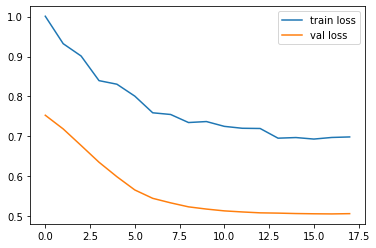

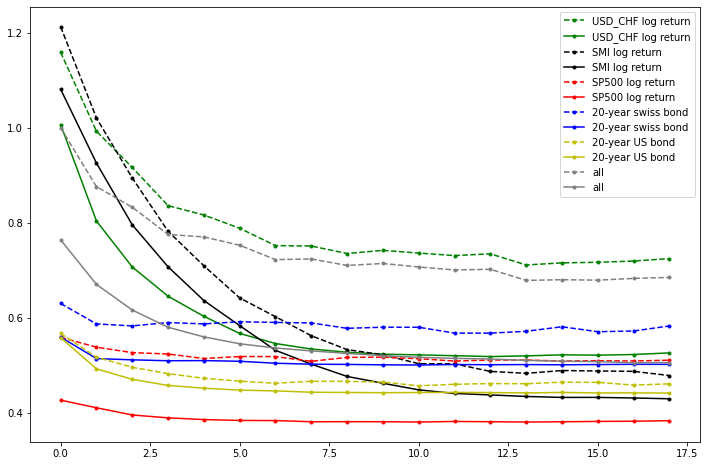

MSE: 54.811716418129244%
REAL MSE: 0.0016462939222503766
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 5.657e+04
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:28:22   Log-Likelihood:                 2764.7
No. Observations:                 676   AIC:                            -5525.
Df Residuals:                     674   BIC:                            -5516.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

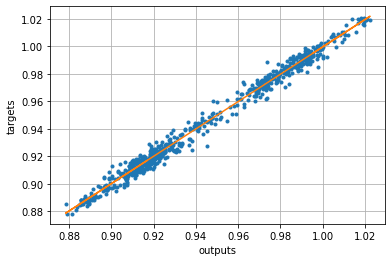

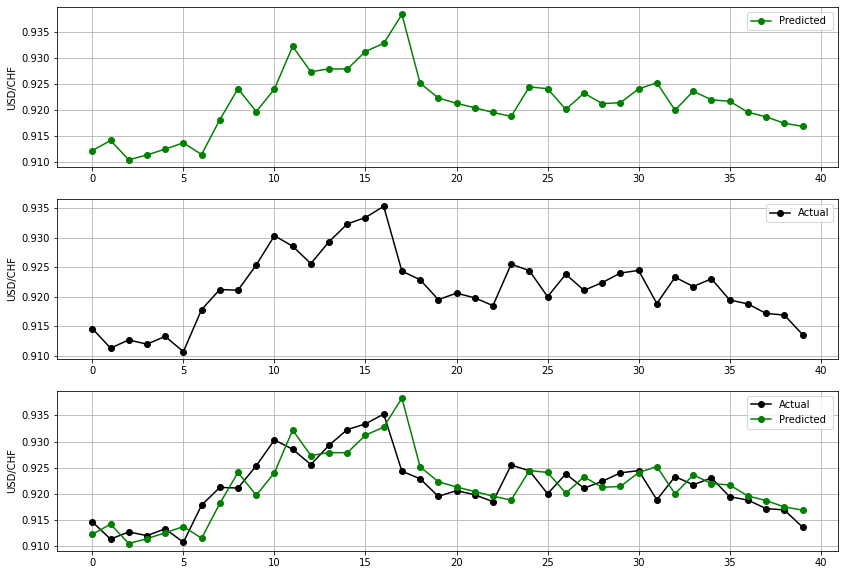

In [23]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 10)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 10)[1:] , label="val loss")
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
name  = ['USD_CHF log return','SMI log return', 'SP500 log return', '20-year swiss bond', '20-year US bond', 'all']
color= ['g', 'k', 'r', 'b', 'y', 'grey']
for i in range(len(aux_loss)): 
  plt.plot(pl.smooth_loss(aux_loss[i], chunksize = 10)[1:],'.--', label=name[i], c=color[i])
  plt.plot(pl.smooth_loss(aux_loss_val[i], chunksize = 10)[1:],'.-' ,label=name[i], c=color[i])
plt.legend()
plt.show()

outputs, targets, MSE = pl.evaluate_aux_trend(model_gru_trend, gru_model_aux, test_x_norm, test_y_norm, device='cpu') 

min = test_x.min(axis=1)
max = test_x.max(axis=1)
o_aux = outputs.reshape(-1,)* (max[:,0]- min[:,0]) + min[:,0] 
t = targets * (max[:,0]- min[:,0]) + min[:,0]
print("REAL MSE:", np.mean((o_aux-t)**2)*100)

pl.regression_result(t,o_aux)

ds.plot_result_price(o_aux, t, nb=40)